In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_california_housing

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.3
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
house = fetch_california_housing()
print(house.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
house.data.shape, house.target.shape

((20640, 8), (20640,))

In [4]:
print(house.data[0:5])
print(house.target[0:5])

[[ 8.32520000e+00  4.10000000e+01  6.98412698e+00  1.02380952e+00
   3.22000000e+02  2.55555556e+00  3.78800000e+01 -1.22230000e+02]
 [ 8.30140000e+00  2.10000000e+01  6.23813708e+00  9.71880492e-01
   2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02]
 [ 7.25740000e+00  5.20000000e+01  8.28813559e+00  1.07344633e+00
   4.96000000e+02  2.80225989e+00  3.78500000e+01 -1.22240000e+02]
 [ 5.64310000e+00  5.20000000e+01  5.81735160e+00  1.07305936e+00
   5.58000000e+02  2.54794521e+00  3.78500000e+01 -1.22250000e+02]
 [ 3.84620000e+00  5.20000000e+01  6.28185328e+00  1.08108108e+00
   5.65000000e+02  2.18146718e+00  3.78500000e+01 -1.22250000e+02]]
[4.526 3.585 3.521 3.413 3.422]


In [5]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    house.data, house.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(11610, 8) (11610,)
(5160, 8) (5160,)
(3870, 8) (3870,)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)


In [8]:
'''
# wide-deep模型不适合序贯型，而函数式API更合适
inputs = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(inputs)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)

concat = keras.layers.concatenate([inputs, hidden2])
outputs = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[inputs], outputs=[outputs])
'''
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        '''定义模型层次'''
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
        
    def call(self, inputs):
        '''完成模型正向计算'''
        hidden1 = self.hidden1_layer(inputs)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([inputs, hidden2])
        outputs = self.output_layer(concat)
        return outputs
model = WideDeepModel() # 直接声明调用类 
# model = keras.models.Sequential([
#     WideDeepModel()
# ]) # 或者通过Sequential封装
model.build(input_shape=(None, 8))

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')

Model: "wide_deep_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  270       
_________________________________________________________________
dense_4 (Dense)              multiple                  930       
_________________________________________________________________
dense_5 (Dense)              multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(x_train_scaled, y_train,
                   validation_data=(x_valid_scaled, y_valid),
                   epochs=100,
                   callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 3s 262us/sample - loss: 1.1012 - val_loss: 0.5682
Epoch 2/100
11610/11610 [==============================] - 1s 100us/sample - loss: 0.4693 - val_loss: 0.4343
Epoch 3/100
11610/11610 [==============================] - 1s 97us/sample - loss: 0.4002 - val_loss: 0.3973
Epoch 4/100
11610/11610 [==============================] - 1s 107us/sample - loss: 0.3776 - val_loss: 0.3814
Epoch 5/100
11610/11610 [==============================] - 1s 98us/sample - loss: 0.3767 - val_loss: 0.3714
Epoch 6/100
11610/11610 [==============================] - 1s 98us/sample - loss: 0.3643 - val_loss: 0.3663
Epoch 7/100
11610/11610 [==============================] - 1s 99us/sample - loss: 0.3489 - val_loss: 0.3633
Epoch 8/100
11610/11610 [==============================] - 1s 111us/sample - loss: 0.3435 - val_loss: 0.3583
Epoch 9/100
11610/11610 [==============================] - 1s 98us/sample - loss: 0

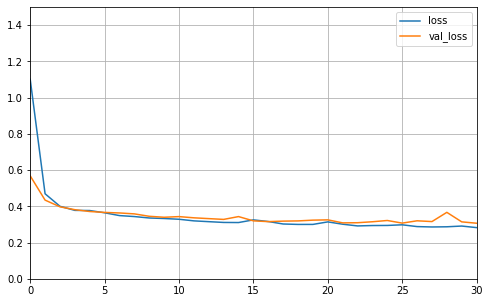

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1.5)
    plt.show()
plot_learning_curves(history)

In [12]:
model.evaluate(x_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.3135707870472309